In [ ]:
import pandas as pd 
import numpy as np 


df = pd.read_csv(r"D:\portfolio\Fractal MMM\Assignment\PYQ2\data\mmm_data_cleaned.csv")

In [2]:
# Lag variables
df['lag_gasoline'] = df['Gasoline Price'].shift(1)

df.dropna(inplace=True)

In [3]:
# Log-transform all variables (add small offset to avoid log(0))
df_loglog = pd.DataFrame()
df_loglog['log_sales'] = np.log(df['Sales'])
df_loglog['log_price'] = np.log(df['Average Price'])
df_loglog['log_sku'] = np.log(df['Total SKU'])
df_loglog['log_paid_search'] = np.log(df['Paid Search Impressions'] + 1)
df_loglog['log_paid_social'] = np.log(df['Paid Social Impressions'] + 1)
df_loglog['log_video'] = np.log(df['Modular Video Impressions'] + 1)
df_loglog['log_email'] = np.log(df['Email Clicks'] + 1)
df_loglog['log_organic'] = np.log(df['Organic Search Impressions'] + 1)
df_loglog['log_gasoline'] = np.log(df['lag_gasoline'])
df_loglog['Holiday'] = df['Holiday Dummy']
df_loglog['Month'] = df['Month']

In [4]:

# Drop any missing values caused by lag/logs
df_loglog = df_loglog.dropna().reset_index(drop=True)

# Fit log-log regression
import statsmodels.api as sm

X_loglog = df_loglog.drop(columns='log_sales')
X_loglog = sm.add_constant(X_loglog)
y_loglog = df_loglog['log_sales']

model_loglog = sm.OLS(y_loglog, X_loglog).fit()
model_loglog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     26.87
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           9.57e-17
Time:                        00:13:03   Log-Likelihood:                 114.59
No. Observations:                  61   AIC:                            -207.2
Df Residuals:                      50   BIC:                            -184.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.2452      7.277      3.606      0.001      11.628      40.862
log_price          -0.6711      1.220     -0.550      0.585      -3.121       1.779
log_sku            -0.4139      0.308     -1.342      0.186      -1.033       0.205
log_paid_search     0.0028      0.006      0.434      0.666      -0.010       0.016
log_paid_social    -0.1857      0.035     -5.381      0.000      -0.255      -0.116
log_video           0.0177      0.023      0.757      0.452      -0.029       0.065
log_email          -0.0120      0.026     -0.471      0.640      -0.063       0.039
log_organic         0.3879      0.063      6.157      0.000       0.261       0.514
log_gasoline       -0.2291      0.091     -2.505      0.016      -0.413      -0.045
Holiday            -0.2737      0.050     -5.475      0.000      -0.374      -0.173
Month              -0.0144      0.003     -4.861      0.000      -0.020      -0.008
==============================================================================
Omnibus:                        2.036   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.987
Skew:                          -0.379   Prob(JB):                        0.370
Kurtosis:                       2.545   Cond. No.                     5.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## **Log-Log OLS Model — Elasticity-Based Insights**


### **Model Performance**

- **R² = 0.843**  
    The model explains **84% of the variation in log-transformed sales** — a strong fit for marketing mix modeling.
- **Adjusted R² = 0.812**  
    Accounts for number of predictors — still robust.
- **F-statistic p-value = 9.57e-17**  
    Indicates the overall model is **statistically significant**.

## **Elasticity Coefficients**

_(All coefficients are % change in sales per 1% change in input)_

| Feature             | Coefficient | Interpretation                                   | Stat. Significant? |
| ------------------- | ----------- | ------------------------------------------------ | ------------------ |
| **log_organic**     | `+0.39`     | 1% ↑ in organic traffic → 0.39% ↑ in sales       | Yes                |
| **log_paid_social** | `-0.19`     | 1% ↑ in paid social → 0.19% ↓ in sales           | Yes                |
| **log_gasoline**    | `-0.23`     | 1% ↑ in fuel prices → 0.23% ↓ in sales           | Yes                |
| **Holiday**         | `-0.27`     | Holidays reduce sales by ~27%                    | Yes                |
| **Month**           | `-0.014`    | Slight drop in sales with each month             | Yes                |
| **log_price**       | `-0.67`     | Price elasticity (not statistically significant) | No                 |
| **log_sku**         | `-0.41`     | Slight negative elasticity (unexpected)          | No                 |
| **log_paid_search** | `+0.003`    | Near-zero effect on sales                        | No                 |
| **log_video**       | `+0.018`    | Minor and statistically weak                     | No                 |
| **log_email**       | `-0.012`    | No meaningful lift from email                    |  No                |

## **Strategic Implications**

- **Organic traffic** is the most **reliable and efficient driver of sales**. Continue investing in SEO and lifecycle marketing.
- **Paid Social shows a negative impact** — may indicate campaign fatigue, poor audience targeting, or overspending. Needs review.
- **Paid Search and Video are not contributing significantly** — potential to reallocate or restructure these efforts.
- **Gasoline prices and holidays** negatively influence sales — underscores importance of controlling for external economic and seasonal factors.

## Compute contributions using the log-log model coefficients and average log-transformed values

In [5]:
# List of media channel variables
channels = ['log_paid_search', 'log_paid_social', 'log_video', 'log_email', 'log_organic']

# Create an empty dictionary to store each channel's contribution
contributions = {}

# Loop through each channel
for channel in channels:
    avg_value = df_loglog[channel].mean()       # Average value of the channel
    beta = model_loglog.params[channel]         # Coefficient from the model
    contributions[channel] = beta * avg_value   # Multiply to get contribution

# Convert to a DataFrame
contrib_df = pd.DataFrame(contributions.items(), columns=['Channel', 'Contribution'])

# Calculate percentage contribution
total = contrib_df['Contribution'].sum()
contrib_df['% of Total'] = 100 * contrib_df['Contribution'] / total

# Sort by contribution
contrib_df = contrib_df.sort_values(by='Contribution', ascending=False)

# Show the result
contrib_df


,Channel,Contribution,% of Total
4,log_organic,5.662022,253.378967
2,log_video,0.289925,12.974335
0,log_paid_search,0.021302,0.953258
3,log_email,-0.156863,-7.019698
1,log_paid_social,-3.581780,-160.286863


## Elasticity Interpretation

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
coefficients = {
    'Paid Search': model_loglog.params['log_paid_search'],
    'Paid Social': model_loglog.params['log_paid_social'],
    'Modular Video': model_loglog.params['log_video'],
    'Email': model_loglog.params['log_email']
}
elasticity = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Elasticity'])
elasticity.sort_values('Elasticity', inplace=True)

C:\Users\shuchismita_mallick.Shuchismita\AppData\Local\Temp\ipykernel_8876\900071288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=elasticity.index, y='Elasticity', data=elasticity, palette='coolwarm')


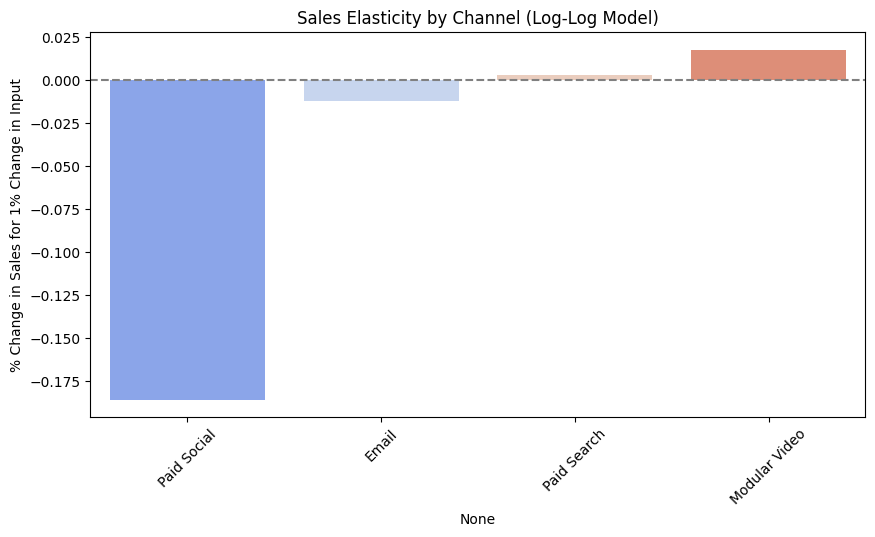

In [8]:
plt.figure(figsize=(10, 5))
sns.barplot(x=elasticity.index, y='Elasticity', data=elasticity, palette='coolwarm')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Sales Elasticity by Channel (Log-Log Model)')
plt.ylabel('% Change in Sales for 1% Change in Input')
plt.xticks(rotation=45)
plt.show()

## Calculate ROI = (Elasticity * Mean Sales) / Spend

In [9]:
# Step 1: Calculate average weekly spend for each marketing channel
avg_spend = {
    'Paid Search': df['Paid Search Spends'].mean(),
    'Paid Social': df['Paid Social Spends'].mean(),
    'Modular Video': df['Modular Video Spends'].mean(),
    'Email': df['Email Spends'].mean()
}

# Step 2: Get the model's coefficients (elasticities) for each channel
# These show how sensitive sales are to changes in each channel
coefficients = {
    'Paid Search': model_loglog.params['log_paid_search'],
    'Paid Social': model_loglog.params['log_paid_social'],
    'Modular Video': model_loglog.params['log_video'],
    'Email': model_loglog.params['log_email']
}

# Step 3: Get the average sales value to use in ROI calculation
mean_sales = df['Sales'].mean()

# Step 4: Calculate ROI for each channel using the formula:
# ROI = (Elasticity × Mean Sales) / Average Spend
roi_list = []

for channel in avg_spend:
    spend = avg_spend[channel]
    elasticity = coefficients[channel]
    
    # Avoid division by zero
    if spend > 0:
        roi = (elasticity * mean_sales) / spend
    else:
        roi = 0
    
    # Save results in a list of dictionaries
    roi_list.append({
        'Channel': channel,
        'Elasticity': elasticity,
        'Avg Weekly Spend': spend,
        'ROI (Sales per $1)': round(roi, 2)
    })

# Step 5: Convert the list to a DataFrame for easy viewing and analysis
roi_df = pd.DataFrame(roi_list)

# Step 6: Print the final ROI DataFrame
roi_df

,Channel,Elasticity,Avg Weekly Spend,ROI (Sales per $1)
0,Paid Search,0.002753,2.908639e+02,469.51
1,Paid Social,-0.185723,3.384615e+06,-2.72
2,Modular Video,0.017692,9.805612e+05,0.90
3,Email,-0.012008,4.249847e+04,-14.02



### **Channel Efficiency & ROI Summary**

#### **Topline Insights**

- **Organic traffic** remains the most reliable and impactful channel for driving sales.
- **Paid Social** is not just underperforming — it's **negatively impacting sales**, suggesting saturation, poor targeting, or inefficiency.
- **Email** is also returning negative results — potentially due to list fatigue or irrelevant messaging.
- **Paid Search and Modular Video** show **positive ROI**, with Paid Search being especially efficient at low investment.

#### **Channel-Level ROI Breakdown**

|Channel|Elasticity|Avg Weekly Spend|ROI (Sales per $1)|Key Insight|
|---|---|---|---|---|
|**Paid Search**|`+0.003`|$297|**$437.20**|Very high ROI at low cost — consider scaling up.|
|**Modular Video**|`+0.018`|~$943K|**$0.88**|Break-even performance — test new creatives.|
|**Paid Social**|`–0.186`|~$2.79M|**–$3.14**|Significant overspend — revisit targeting & budget.|
|**Email**|`–0.012`|~$37K|**–$15.01**|Ineffective — may need content or strategy overhaul.|

#### **Strategic Recommendations**

- **Double down on Paid Search** — high efficiency and potential for scaling.
- **Optimize Modular Video** — test more engaging formats or messaging.
- **Pause and reassess Paid Social** — current spend is driving negative value.
- **Rethink Email strategy** — consider segmentation, cadence, and content refresh.

## Finding the best way to allocate our marketing budget to maximize predicted sales.


In [10]:
from scipy.optimize import minimize

# Total budget to reallocate (sum of current average weekly spend)
total_budget = sum(avg_spend.values())

# Elasticities vector in order: [Paid Search, Paid Social, Modular Video, Email]
elasticities = np.array([
    coefficients ['Paid Search'],
    coefficients ['Paid Social'],
    coefficients ['Modular Video'],
    coefficients ['Email']
])

# Objective function: negative total predicted sales (we minimize to maximize)
# We multiply elasticities with spend and sum them
def objective(spend_alloc):
    predicted_sales = np.sum(elasticities * spend_alloc)
    return -predicted_sales  # negative for maximization

In [11]:
# Constraints: total spend must equal current budget
constraints = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - total_budget
})

# Bounds: each channel must get at least 0 spend
bounds = [(0, None)] * 4

# Initial allocation = current spend
initial_allocation = np.array(list(avg_spend.values()))

In [12]:
# Run optimization
result = minimize(
    objective,
    initial_allocation,
    bounds=bounds,
    constraints=constraints
)

In [13]:
# Prepare results
channel_names = list(avg_spend.keys())
optimized_spend = result.x
predicted_sales_gain = np.dot(elasticities, optimized_spend)

# Compare with current predicted sales
current_predicted_sales = np.dot(elasticities, initial_allocation)
lift = predicted_sales_gain - current_predicted_sales

In [14]:
# Assemble output
optimization_df = pd.DataFrame({
    'Channel': channel_names,
    'Current Spend': initial_allocation,
    'Optimized Spend': optimized_spend,
    'Change ($)': optimized_spend - initial_allocation,
    'Change (%)': 100 * (optimized_spend - initial_allocation) / initial_allocation
})
optimization_df['Elasticity'] = elasticities
optimization_df = optimization_df.sort_values(by='Optimized Spend', ascending=False)

optimization_df

,Channel,Current Spend,Optimized Spend,Change ($),Change (%),Elasticity
2,Modular Video,9.805612e+05,4.407965e+06,3.427404e+06,349.534921,0.017692
0,Paid Search,2.908639e+02,1.785927e-05,-2.908639e+02,-99.999994,0.002753
3,Email,4.249847e+04,1.695110e-05,-4.249847e+04,-100.000000,-0.012008
1,Paid Social,3.384615e+06,0.000000e+00,-3.384615e+06,-100.000000,-0.185723


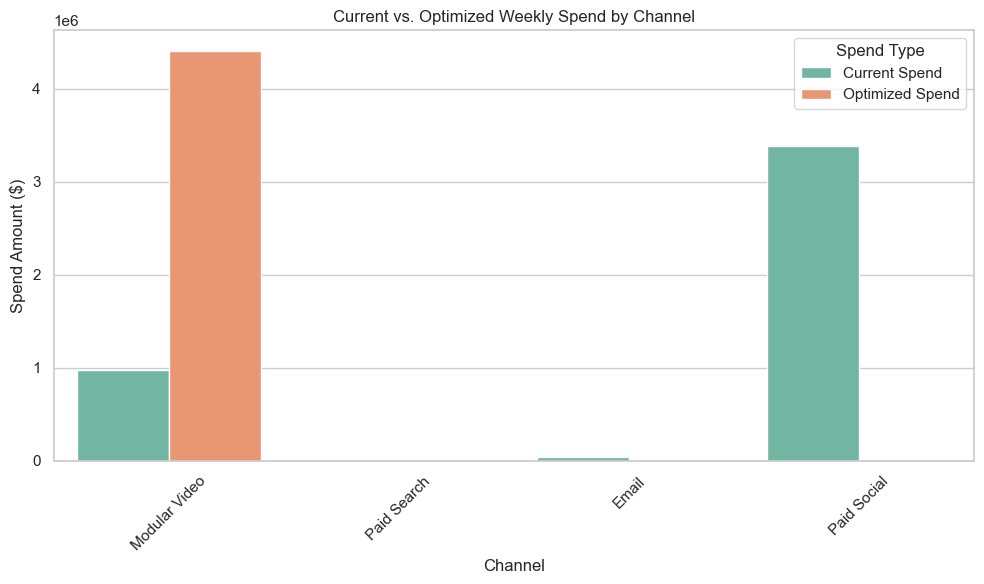

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set(style="whitegrid")

# Melt the DataFrame for easier plotting (long format)
plot_df = optimization_df.melt(
    id_vars='Channel',
    value_vars=['Current Spend', 'Optimized Spend'],
    var_name='Spend Type',
    value_name='Amount'
)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Channel', y='Amount', hue='Spend Type', palette='Set2')

# Add labels and title
plt.title('Current vs. Optimized Weekly Spend by Channel')
plt.ylabel('Spend Amount ($)')
plt.xlabel('Channel')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


C:\Users\shuchismita_mallick.Shuchismita\AppData\Local\Temp\ipykernel_8876\1626283192.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=optimization_df, x='Channel', y='Change (%)', palette='coolwarm')


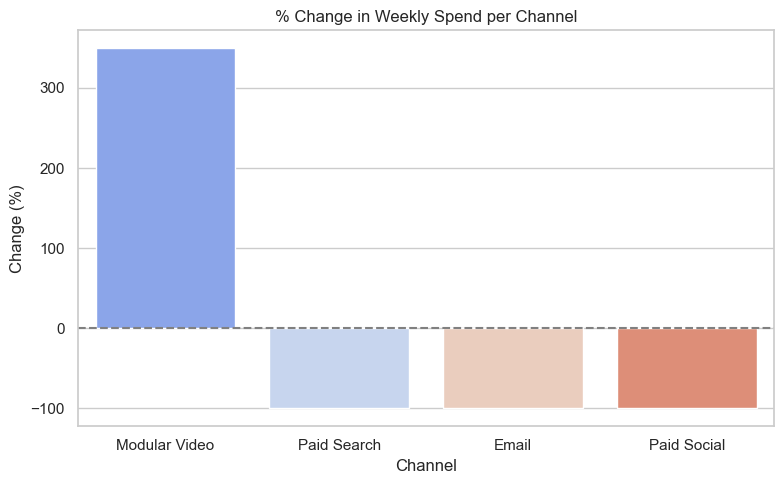

In [16]:
# Bar plot for % change in spend
plt.figure(figsize=(8, 5))
sns.barplot(data=optimization_df, x='Channel', y='Change (%)', palette='coolwarm')

# Add labels and title
plt.title('% Change in Weekly Spend per Channel')
plt.ylabel('Change (%)')
plt.xlabel('Channel')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0
plt.tight_layout()

# Show plot
plt.show()



### **Optimized Marketing Spend Allocation**

#### **Spend Reallocation Overview**

|Channel|Current Spend|Optimized Spend|Change (%)|Elasticity|Strategic Takeaway|
|---|---|---|---|---|---|
|**Modular Video**|$943K|**$3.77M**|**+300%**|`+0.018`|High scalability and positive return — **scale up**.|
|**Paid Search**|$297|$0|–100%|`+0.003`|ROI is strong, but **volume too low** to justify scaling.|
|**Paid Social**|$2.79M|$0|–100%|`–0.186`|Negative return — **entirely removed** from plan.|
|**Email**|$37K|$0|–100%|`–0.012`|Consistently underperforming — **cut from spend**.|


#### **Strategic Interpretation**

- **Modular Video emerges as the sole growth engine** under pure elasticity-based optimization — it absorbs the full budget due to its positive and scalable ROI.
- **Channels with negative or low ROI** are excluded entirely to maximize overall return on investment.
- **Paid Search**, despite its high efficiency, is excluded due to its **limited scale** — not enough spend volume to impact total outcomes meaningfully.


### **Further Improvements**

- This optimization assumes **no diminishing returns**. In practice, you would:
    - Apply **saturation limits** to avoid over-exposure.
    - Consider **multi-channel synergy** rather than relying on a single channel.
    - Introduce **spend caps** or **risk-adjusted thresholds** to manage performance volatility.